<a href="https://colab.research.google.com/github/Kira1108/PromptEngineering/blob/main/Prompt_Langchain_Subclassing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from IPython.display import clear_output
!pip install langchain
clear_output()

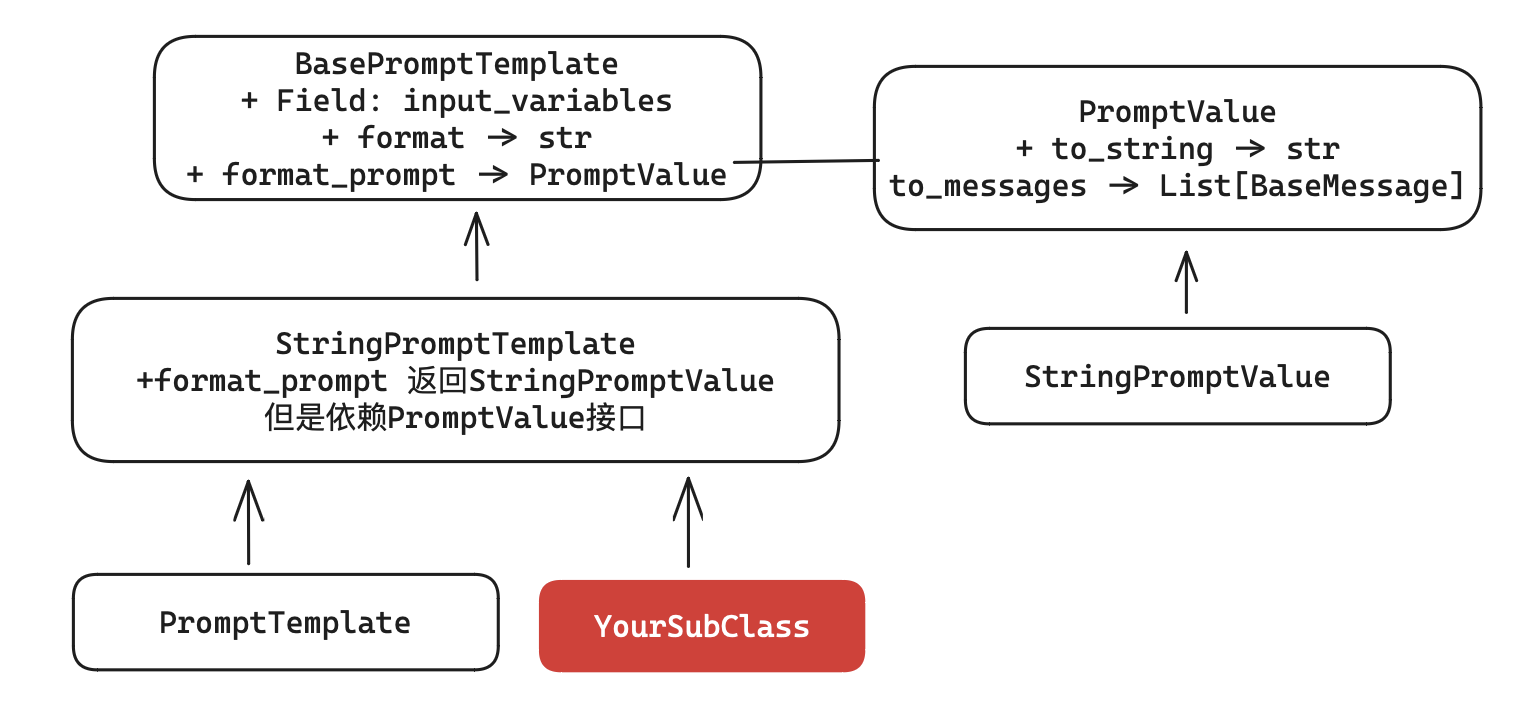

**Langchain的基础对象了解一下**

In [4]:
from __future__ import annotations

from abc import ABC, abstractmethod
from typing import (
    Any,
    Dict,
    Generic,
    List,
    NamedTuple,
    Optional,
    Sequence,
    TypeVar,
    Union,
)

from pydantic import BaseModel, Extra, Field, root_validator

# 一个message需要包含一个内容，和注入的参数列表
class BaseMessage(BaseModel):
    """Message object."""
    content: str
    additional_kwargs: dict = Field(default_factory=dict)

    @property
    @abstractmethod
    def type(self) -> str:
        """Type of the message, used for serialization."""

# message的一个实现
class HumanMessage(BaseMessage):
    """Type of message that is spoken by the human."""

    example: bool = False

    @property
    def type(self) -> str:
        """Type of the message, used for serialization."""
        return "human"

class PromptValue(BaseModel, ABC):
    # 返回string的方法
    @abstractmethod
    def to_string(self) -> str:
        """Return prompt as string."""

    # 返回一个list的message
    @abstractmethod
    def to_messages(self) -> List[BaseMessage]:
        """Return prompt as messages."""

class StringPromptValue(PromptValue):
    """实现类要关注怎么折腾String和message"""
    text: str

    def to_string(self) -> str:
        """Return prompt as string."""
        return self.text

    def to_messages(self) -> List[BaseMessage]:
        """Return prompt as messages."""
        return [HumanMessage(content=self.text)]

In [21]:
from __future__ import annotations

import json
from abc import ABC, abstractmethod
from pathlib import Path
from typing import Any, Callable, Dict, List, Mapping, Optional, Set, Union

import yaml
from pydantic import BaseModel, Extra, Field, root_validator

from langchain.formatting import formatter


class BasePromptTemplate(BaseModel, ABC):
    """Base class for all prompt templates, returning a prompt."""

    input_variables:List[str]

    @abstractmethod
    def format_prompt(self, **kwargs: Any) -> PromptValue:
        """这儿的东西拿出来可以String，也可以弄成MessagesList"""
        

    @abstractmethod
    def format(self, **kwargs: Any) -> str:
        """搞成String"""


class StringPromptTemplate(BasePromptTemplate, ABC):
    """中间父类，实现format_prompt方法"""

    def format_prompt(self, **kwargs: Any) -> PromptValue:
        return StringPromptValue(text=self.format(**kwargs))

class PromptTemplate(StringPromptTemplate):
    def format(self, **kwargs: Any) -> str:
        """实现format转string的方法"""
        ...

### 写一个Prompt子类

In [20]:
from langchain.prompts import StringPromptTemplate
from pydantic import BaseModel, validator


# 这个VarPromptTemplate的原型（类似js）是BasePromptTemplate
# 所以构造函数需要有input_variables

class VarPromptTemplate(StringPromptTemplate, BaseModel):

    # 继承父类BasepromptTemplate的时候，就要求，构造函数必须传一个input_variables
    # 这里就验证一下，input_variables = ['var'], 只有一个元素，且是 'var'
    # 写fastapi的时候，这么搞一下参数验证也挺好的。
    @validator("input_variables")
    def validate_input_variables(cls, v):
        if len(v) != 1 or "var" not in v:
            raise ValueError("var 必须是 input_variable 里面唯一的元素.")
        return v

    # 'var'必须在format函数以kwargs的形式传入
    def format(self, **kwargs) -> str:
        # 从kwargs中拿到参数
        var = kwargs["var"]

        # 把参数放到prompt里面去
        prompt = f"""
        Hey I got an input var = `{var}`
        """.strip()
        return prompt

VarPromptTemplate(input_variables = ['var']).format(var = "fuck")

'Hey I got an input var = `fuck`'

也可以用这种方式写默认的list参数，真特么恶心

In [26]:

from pydantic import Field

class VarPromptTemplate(StringPromptTemplate, BaseModel):

    # 不能使用list直接作为默认参数，所以采用Field(default_factory = ...)
    # 还是提供一个工厂方法比较好
    input_variables:List[str] = Field(default_factory = lambda :['var'])

    @validator("input_variables")
    def validate_input_variables(cls, v):
        if len(v) != 1 or "var" not in v:
            raise ValueError("var 必须是 input_variable 里面唯一的元素.")
        return v


    def format(self, **kwargs) -> str:
        var = kwargs["var"]

        prompt = f"""
        Hey I got an input var = `{var}`
        """.strip()
        return prompt

VarPromptTemplate().format(var = "haha")

'Hey I got an input var = `haha`'